In [5]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
cred_fp = '/ebs_volume/data/Credible/'
ncred_fp = '/ebs_volume/data/notCredible/'

In [7]:
articles = pd.DataFrame(columns=('label',
                                 'text',
                                 'title',
                                 'date',
                                 'source',
                                 'images',
                                 'videos',
                                 'url'))
i = 0    
for root, dirs, files in os.walk(cred_fp):
    for file in files:
        if file.endswith(".txt") and 'api' not in file:
             curr_file = os.path.join(root, file)
             #print curr_file
             with open(curr_file) as json_file:
                try:
                    data = json.load(json_file)
                    articles.loc[i] = [0,data["text"],data["title"],data["date"],data["source"],data["images"],data["videos"],data["url"]]
                    i+=1
                except ValueError:
                    continue

for root, dirs, files in os.walk(ncred_fp):
    for file in files:
        if file.endswith(".txt") and 'api' not in file:
             curr_file = os.path.join(root, file)
             #print curr_file
             with open(curr_file) as json_file:
                try:
                    data = json.load(json_file)
                    articles.loc[i] = [1,data["text"],data["title"],data["date"],data["source"],data["images"],data["videos"],data["url"]]
                    i+=1
                except ValueError:
                    continue

In [8]:
print(articles[articles["label"]==1.].shape)
print(articles[articles["label"]==0.].shape)
print(articles["source"].unique())

(3861, 8)
(1362, 8)
['national-geographic' 'bbc-news' 'reuters' 'new-york-times' 'bostonglobe'
 'latimes' 'the-wall-street-journal' 'nature' 'the-washington-post'
 'usa-today' 'independent' 'the-new-york-times' 'infostormer'
 'activistpost' 'ItMakesSenseBlog' 'usapoliticsnow' 'usanewsflash'
 'darkmoon' 'rickwells' 'embols' 'usfanzone' 'success-street' 'usasupreme'
 'dcclothesline' 'gopthedailydose' 'empirenews']


In [9]:
articles = articles.sample(frac=1) #shuffle
articles[1:5]
#print articles.shape

label                                               text  \
2126    1.0  By Derrick Broze\n\nPresident Trump has invoke...   
2814    1.0  Earlier today, President Donald Trump‚Äôs son Er...   
1855    1.0  By Claire Bernish\n\nFirst, Iceland, and now S...   
328     0.0  FILE PHOTO: The U.S. Capitol building is seen ...   

                                                  title        date  \
2126  The Trump Administration Is Attempting To Bloc...  03-13-2017   
2814  Don Jr. Hits Back at Chelsea Handler for Makin...  03-20-2017   
1855  Spain Sets Massive Precedent ‚Äî Charges Its Cen...  02-20-2017   
328   Exclusive: Republicans mostly blame Congress f...  03-29-2017   

            source                                             images videos  \
2126  activistpost  [http://www.activistpost.com/wp-content/upload...     []   
2814  usanewsflash  [https://scontent-vie1-1.xx.fbcdn.net/v/t1.0-9...     []   
1855  activistpost  [http://www.activistpost.com/wp-content/upload...     []   
328        reuters  [http://s3.reutersmedia.net/resources/r/?m=02&...     []   

                                                    url  
2126  http://www.activistpost.com/2017/03/the-trump-...  
2814  http://www.usanewsflash.com/don-jr-hits-back-c...  
1855  http://www.activistpost.com/2017/02/spain-sets...  
328   http://www.reuters.com/article/us-usa-healthca...

In [127]:
#### Stemming and tokenize 

import nltk
from nltk.tokenize import RegexpTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

token_dict = {}
#stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
        #print(stemmed)
    return stemmed

def tokenize(text):
    tokenizer = nltk.RegexpTokenizer(r'\w+') #Remove punctuation, preserve caps
    #tokens= nltk.word_tokenize(text)
    tokens = tokenizer.tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return [w for w in tokens if len(w) >2] #Include words that are at least length 2

#print(articles['text'][0],tokenize(articles['text'][0]))
print(tokenize("BREAKING NEWS NOW now! S!  de"))

['BREAKING', 'NEWS', 'NOW', 'now']


In [150]:
#Frequently occuring words in titles

import operator
#from sklearn.feature_extraction import text 
#stop_words = text.ENGLISH_STOP_WORDS

count_vectorizer = CountVectorizer(analyzer='word', ngram_range = (1,1),min_df=0.0,stop_words='english',tokenizer=tokenize,lowercase=False)

#credible words
counts = count_vectorizer.fit_transform(articles[articles['label'] == 0]['title'].values)
counts = counts.toarray()
#print counts.shape
#Get Vocab
vocab = count_vectorizer.get_feature_names()
# Sum up the counts of each vocabulary word
dist = np.sum(counts, axis=0)
# For each, print the vocabulary word and the number of times it appears in the training set
c_wordcounts = {}
for tag, count in zip(vocab, dist):
    c_wordcounts[tag] = count

sorted_cred_counts = sorted(c_wordcounts.items(), key=operator.itemgetter(1),reverse=True)
print('\nTop Words in credible news articles (titles only)\n')
print(sorted_cred_counts[1:25])

#Non- credible words
counts = count_vectorizer.fit_transform(articles[articles['label'] == 1]['title'].values)
counts = counts.toarray()
#print counts.shape
#Get Vocab
vocab = count_vectorizer.get_feature_names()
# Sum up the counts of each vocabulary word
dist = np.sum(counts, axis=0)
# For each, print the vocabulary word and the number of times it appears in the training set
nc_wordcounts = {}
for tag, count in zip(vocab, dist):
    nc_wordcounts[tag] = count

sorted_ncred_counts = sorted(nc_wordcounts.items(), key=operator.itemgetter(1),reverse=True)
print('\nTop Words in non-credible news articles (titles only)\n')
print(sorted_ncred_counts[1:25])

c_nc_wordcounts={}
for key,values in nc_wordcounts.items():
    if key not in c_wordcounts.keys():
        c_nc_wordcounts[key] = values
        
sorted_c_nc_counts = sorted(c_nc_wordcounts.items(), key=operator.itemgetter(1),reverse=True)
print ('\nTop Words in non-credible news articles (titles only), that do not appear in credible news\n')
print (sorted_c_nc_counts[1:25])


Top Words in credible news articles (titles only)

[('House', 81), ('says', 59), ('The', 56), ('Brexit', 52), ('Donald', 50), ('White', 47), ('Russia', 46), ('May', 42), ('GOP', 36), ('Health', 36), ('health', 33), ('London', 32), ('Obama', 32), ('New', 31), ('attack', 30), ('care', 29), ('How', 28), ('President', 28), ('Theresa', 27), ('This', 27), ('Republicans', 26), ('What', 26), ('new', 26), ('With', 25)]

Top Words in non-credible news articles (titles only)

[('The', 819), ('Obama', 457), ('Just', 423), ('USA', 395), ('Newsflash', 373), ('For', 356), ('BREAKING', 277), ('And', 270), ('What', 266), ('President', 234), ('With', 218), ('After', 206), ('About', 158), ('New', 158), ('Are', 151), ('That', 150), ('You', 148), ('This', 147), ('Will', 144), ('From', 138), ('House', 127), ('Was', 124), ('White', 119), ('News', 118)]

Top Words in non-credible news articles (titles only), that do not appear in credible news

[('BREAKING', 277), ('Media', 112), ('CNN', 93), ('TRUMP', 86), 

In [151]:
#Frequently occuring words in text

import operator
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS

count_vectorizer = CountVectorizer(analyzer='word', ngram_range = (1,1),min_df=0.1,stop_words='english',tokenizer=tokenize, lowercase=False)

#credible words
counts = count_vectorizer.fit_transform(articles[articles['label'] == 0]['text'].values)
counts = counts.toarray()
#print counts.shape
#Get Vocab
vocab = count_vectorizer.get_feature_names()
# Sum up the counts of each vocabulary word
dist = np.sum(counts, axis=0)
# For each, print the vocabulary word and the number of times it appears in the training set
c_wordcounts = {}
for tag, count in zip(vocab, dist):
    c_wordcounts[tag] = count

sorted_cred_counts = sorted(c_wordcounts.items(), key=operator.itemgetter(1),reverse=True)
print('Top Words in credible news articles (text only)\n')
print(sorted_cred_counts[1:25])

#Non- credible words
counts = count_vectorizer.fit_transform(articles[articles['label'] == 1]['text'].values)
counts = counts.toarray()
#print counts.shape
#Get Vocab
vocab = count_vectorizer.get_feature_names()
# Sum up the counts of each vocabulary word
dist = np.sum(counts, axis=0)
# For each, print the vocabulary word and the number of times it appears in the training set
nc_wordcounts = {}
for tag, count in zip(vocab, dist):
    nc_wordcounts[tag] = count

sorted_ncred_counts = sorted(nc_wordcounts.items(), key=operator.itemgetter(1),reverse=True)
print('\nTop Words in non-credible news articles (text only)\n')
print(sorted_ncred_counts[1:25])

c_nc_wordcounts={}
for key,values in nc_wordcounts.items():
    if key not in c_wordcounts.keys():
        c_nc_wordcounts[key] = values
        
sorted_c_nc_counts = sorted(c_nc_wordcounts.items(), key=operator.itemgetter(1),reverse=True)
print ('\nTop Words in non-credible news articles (text only), that do not appear in credible news\n')
print (sorted_c_nc_counts[1:25])

Top Words in credible news articles (text only)

[('The', 8311), ('Trump', 7602), ('House', 3228), ('people', 2296), ('President', 2124), ('But', 1837), ('White', 1805), ('story', 1766), ('March', 1644), ('2017', 1622), ('year', 1606), ('president', 1527), ('main', 1399), ('time', 1370), ('reading', 1357), ('Advertisement', 1347), ('new', 1343), ('like', 1232), ('years', 1184), ('Donald', 1174), ('government', 1170), ('New', 1164), ('just', 1136), ('campaign', 1131)]

Top Words in non-credible news articles (text only)

[('Trump', 10478), ('President', 5126), ('said', 4727), ('people', 4434), ('Obama', 4203), ('com', 3453), ('just', 2981), ('government', 2879), ('time', 2837), ('This', 2822), ('like', 2755), ('American', 2389), ('And', 2286), ('House', 2198), ('going', 2162), ('media', 2144), ('They', 2134), ('state', 1972), ('know', 1948), ('years', 1939), ('country', 1929), ('But', 1902), ('right', 1869), ('way', 1784)]

Top Words in non-credible news articles (text only), that do no

In [158]:
mask = np.column_stack([articles['text'].str.contains(r"Facebook", na=False)])
articles.loc[mask.any(axis=1)]['text'][3260]

'Share With Your Friends On Facebook, Twitter, Everywhere\n\n\n\n\n\n\n\n\n\n170 Shares\n\nRep Jason Chaffetz (R-UT), chairman of the House Oversight committee, describes the latest intruder breach into the White House grounds as ‚Äúcomplete and utter total failure.‚Äù He says, ‚ÄúLook, they have concentric circles that radiate out from where the President is no matter where he is. But the White House is probably the most targeted place on the face of the planet. We spend billions of dollars to secure it. The President was in the residence that night.‚Äù\n\n‚ÄúHow some person,‚Äù says Chaffetz, ‚Äúcan go up to the fence, jump it, be on the ground for what Secretary Kelly, I got off the phone with him literally about an hour ago. Secretary Kelly told me that this person was there, on the ground for 17 minutes, went undetected, was able to get up next to the White House, hide behind a pillar, look through a window, rattle the door handle, is just beyond comprehension.‚Äù\n\nChaffetz note

In [128]:
###Source: https://buhrmann.github.io/tfidf-analysis.html

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].tolist()#.toarray()
    else:
        D = Xtr.tolist()##.todense()

    #D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    #print(tfidf_means[0])
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    #df2=[]
    labels = np.unique(y)
    #print(labels)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        #feats_df['label'] = label
        feats_df.label = label
        #print(feats_df)
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        set_label = 'Non-Credible News Articles'
        if df.label==0.0:
            set_label = 'Credible News Articles'
        ax.set_title("label = " + str(set_label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

#print(top_mean_feats(tfidf_matrix,feature_names))

Number of features: 272
Number of examples: 5223

Plot Features in a 2 Diensional space using PCA


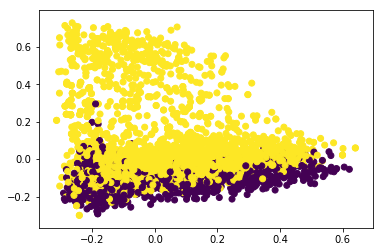


Top 25 most frequently occuring words in the corpus

[('york', 271), ('years', 270), ('year', 269), ('www', 268), ('wrote', 267), ('world', 266), ('working', 265), ('work', 264), ('won', 263), ('white', 262), ('went', 261), ('week', 260), ('website', 259), ('way', 258), ('washington', 257), ('war', 256), ('want', 255), ('view', 254), ('video', 253), ('using', 252), ('used', 251), ('use', 250), ('united', 249), ('twitter', 248), ('trying', 247)]

Top 25 TFIDF scores by class



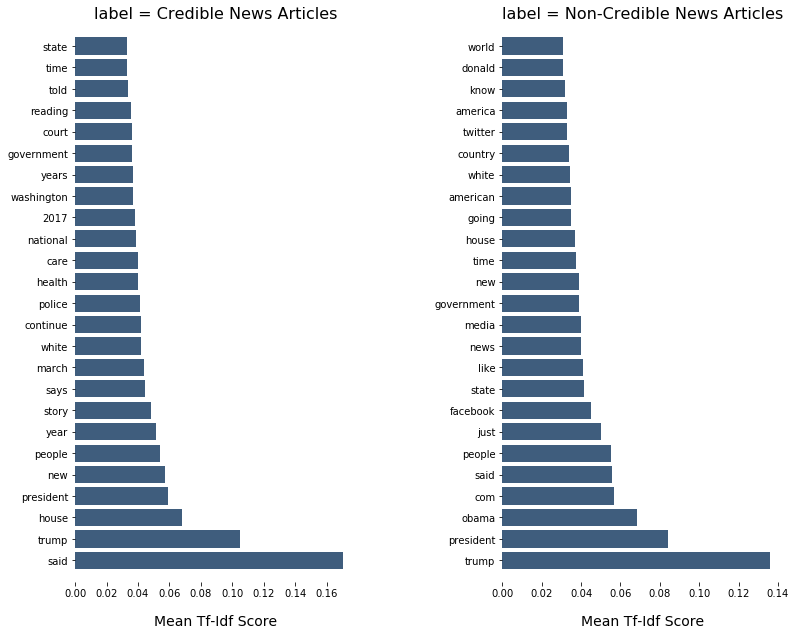

In [131]:
#unigrams

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

tf_uni = TfidfVectorizer(analyzer='word', ngram_range = (1,1),min_df=0.1,stop_words='english',tokenizer=tokenize)
tfidf_matrix_uni =  tf_uni.fit_transform(articles['text']).todense()
feature_names_uni = tf_uni.get_feature_names() 
print('Number of features: %d' % len(feature_names_uni))
print('Number of examples: %d' % len(tfidf_matrix_uni))

#Plot features in two dimensional PCA with labels as colors
print('\nPlot Features in a 2 Diensional space using PCA')
pca = PCA(n_components=2).fit(tfidf_matrix_uni)
data2D = pca.transform(tfidf_matrix_uni)
plt.scatter(data2D[:,0], data2D[:,1], c=articles['label'])           
plt.show()

#Top 25 tfidf by class
print('\nTop 25 TFIDF scores by class\n')
top25 = top_feats_by_class(tfidf_matrix_uni,articles['label'],feature_names_uni)
plot_tfidf_classfeats_h(top25)

Number of features: 12
Number of examples: 5223

Plot Features in a 2 Diensional space using PCA


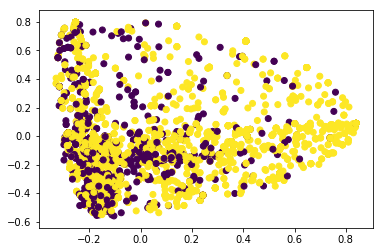


Top 25 most frequently occuring words in the corpus

[('white house', 11), ('united states', 10), ('trump administration', 9), ('president trump', 8), ('president donald trump', 7), ('president donald', 6), ('obama administration', 5), ('new york', 4), ('march 2017', 3), ('hillary clinton', 2), ('donald trump', 1), ('barack obama', 0)]

Top 25 TFIDF scores by class



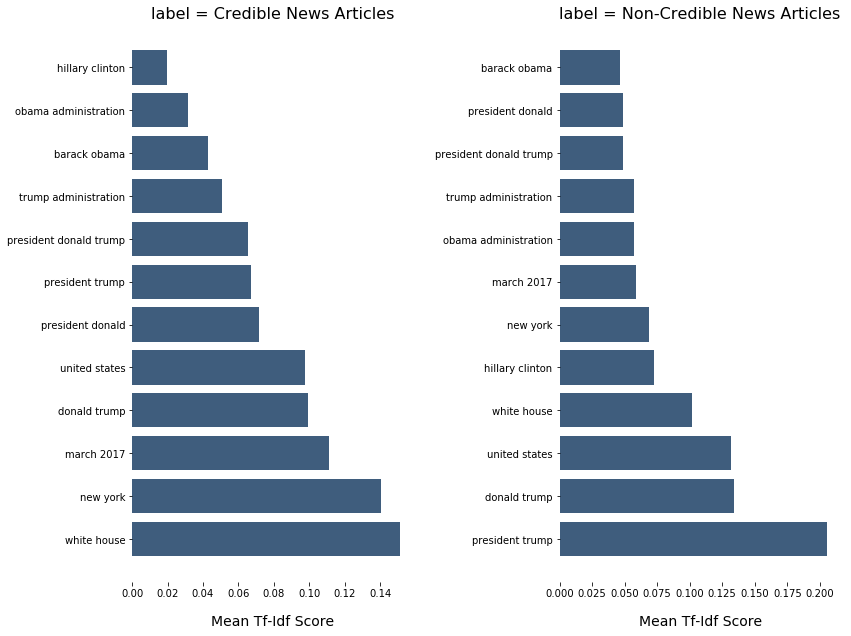

In [135]:
#bigrams/trigrams

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

tf_bi = TfidfVectorizer(analyzer='word', ngram_range = (2,3),min_df=0.1,stop_words='english',tokenizer=tokenize)
tfidf_matrix_bi =  tf_bi.fit_transform(articles['text']).todense()
feature_names_bi = tf_bi.get_feature_names() 
print('Number of features: %d' % len(feature_names_bi))
print('Number of examples: %d' % len(tfidf_matrix_bi))

#Plot features in two dimensional PCA with labels as colors
print('\nPlot Features in a 2 Diensional space using PCA')
pca = PCA(n_components=2).fit(tfidf_matrix_bi)
data2D = pca.transform(tfidf_matrix_bi)
plt.scatter(data2D[:,0], data2D[:,1], c=articles['label'])           
plt.show()

#Top 25 tfidf by class
print('\nTop 25 TFIDF scores by class\n')
top25_bi = top_feats_by_class(tfidf_matrix_bi,articles['label'],feature_names_bi)
plot_tfidf_classfeats_h(top25_bi)

In [ ]:
#Build features based on text
# % of words in all caps, 
# % with ?
# % with ??
# % with excalamation
# % with bold
#Remove words start with @

In [ ]:
#### Perform Sentiment Analysis

In [31]:
import sys
import csv
from collections import defaultdict

# wget https://bootstrap.pypa.io/ez_setup.py -O - | sudo python
# sudo easy_install --upgrade pip
# pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

for index, row in articles.iterrows():
    text = row['text']#.encode("ascii","ignore")
    #print title
    #for sentence in sentences:
    vs = analyzer.polarity_scores(text)
    #print("{:-<65} {}".format(title, str(vs)))
    #neg,neu,pos,compuound
    print(row['title'],row['label'],vs['neg'],vs['neu'],vs['pos'],vs['compound'])

Global Leftists Vilify Rep Steve King For Pride In Heritage As White American - 1.0 0.052 0.809 0.139 0.9954
This Is Why We Find 'Ugly' Animals Cute 0.0 0.062 0.79 0.147 0.9864
Did The U.S. Really Bomb A Mosque In Syria? Many Factors At Play In Latest Reports 1.0 0.161 0.726 0.113 -0.9979
ABC News Reporter Attacked on LIVE TV By THUG Wearing Hockey Mask [Video] - 1.0 0.077 0.852 0.071 -0.4939
Think Tank Admits Automation Could Replace 250,000 Government Jobs in the UK 1.0 0.047 0.843 0.11 0.9806
U.S. Preparing Cases Linking North Korea to Theft at N.Y. Fed 0.0 0.067 0.914 0.019 -0.4215
Fmr Clinton Fundraiser Releases Secret Video Over Fears They May Have Him ASSASSINATED 1.0 0.07 0.874 0.056 -0.7313
NEW: Trump‚Äôs border wall could save Americans BILLIONS of dollars 1.0 0.0 0.738 0.262 0.4939
Colon and Rectal Cancers Rising in Young People 0.0 0.14 0.779 0.081 -0.9986
Extreme VETTING 1.0 0.0 1.0 0.0 0.0
Striking Photos Show The People vs. Climate Change 0.0 0.041 0.829 0.13 0.9334
BREA

In [ ]:
####Build Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#classifier = MultinomialNB()
#count_vectorizer = CountVectorizer()
#count_vectorizer = CountVectorizer()

pipeline = Pipeline([
    ('vectorizer',  CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier',  MultinomialNB()) ])

#pipeline.fit(train['text'].values, train['label'].values)
#pipeline.predict(test['text']) 

In [ ]:
#Train with Performing group k fold cross validation

In [ ]:

from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

k_fold = KFold(n=len(train), n_folds=6)
scores = []
f_scores=[]
confusion = numpy.array([[0, 0], [0, 0]])
for train_indices, test_indices in k_fold:
    train_text = train.iloc[train_indices]['title'].values
    train_y = train.iloc[train_indices]['label'].values
    #print train_text,train_y

    test_text = train.iloc[test_indices]['title'].values
    test_y = train.iloc[test_indices]['label'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    confusion += confusion_matrix(test_y, predictions)
    f_score = f1_score(test_y, predictions)
    score = accuracy_score(test_y, predictions)
    scores.append(score)
    f_scores.append(f_score)
    
print 'Cross Validation Metrics'
print('Total articles classified:', len(train))
print('Accuracy Score:', round(sum(scores)/len(scores),3))
print('F1 Score:', round(sum(f_scores)/len(f_scores),3))
print('Confusion matrix:')
print(confusion)

In [10]:
from sklearn.model_selection import GroupKFold

#X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 8.8, 9, 10]
#y = ["a", "b", "b", "b", "c", "c", "c", "d", "d", "d"]
groups = articles["source"].unique()
gkf = GroupKFold(n_splits=5)

for train, test in gkf.split(articles["text"], articles["label"], groups=groups):
     print("%s %s" % (train, test))

ValueError: Found input variables with inconsistent numbers of samples: [4139, 4139, 23]

In [4]:
train, test = train_test_split(articles, test_size = 0.2)
print("train data shape:", train.shape)
print("test data shape:", test.shape)

train data shape: (2530, 8)
test data shape: (633, 8)


In [10]:
len(articles[articles["label"]==1.])

2610

In [11]:
len(articles[articles["label"]==0.])

553